# Association

Modelling the direct labelling of observations from different population components.

Model definition and simulation is done using pyStan with code in the `stan/` directory.

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from math import ceil
import cmdstanpy

import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

In [3]:
# for nice plots when shown on GitHub nb viewer
import seaborn as sns
sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

## A simple mixture model

Consider observations drawn from a mixture of 2 gaussian distributions with different means and the same standard deviation. Each population has an associated weight, $w$, the set of which forms a 2-simplex. The model can be parameterised with a latent categorical variable or *label*, $\lambda$:

$$
\lambda \sim Categorical(w) 
$$

The observation $y_n$ is distributed according to which mixture componenet it is generated from.

$$
y_k \sim Normal(\mu_k, \sigma^2)   
$$
    
In order to treat this model in Stan, we marginalise over the discrete parameter:

$$
p(y \ | \ w, \mu, \sigma) = \sum_{k = 1}^2 w_k Normal( y \ | \ \mu_k, \sigma^2)
$$
    
  

In [4]:
# compile the stan simulation
simu_file = 'stan/simple_mixture_sim.stan'
simulation = cmdstanpy.CmdStanModel(stan_file=simu_file)

chain 1 |          | 00:00 Status

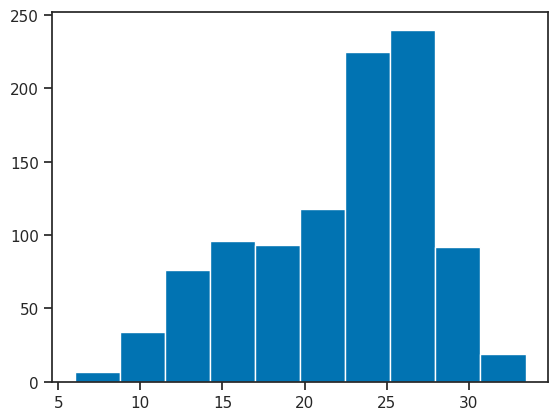

In [5]:
# Use stan to simulate draws from this mixutre model
simu_parameters = {'mu' : [15, 25],
                   'sigma' : 3, 
                   'w' : [0.3, 0.7], 
                   'N_obs' : 1000}

simu = simulation.sample(data=simu_parameters, fixed_param=True, 
                         iter_sampling=1, chains=1, seed=42)

# plot the simulation
y_simu = simu.stan_variable("y")[0]
plt.hist(y_simu);

In [6]:
# compile the stan model
model_file = 'stan/simple_mixture.stan'
model = cmdstanpy.CmdStanModel(stan_file=model_file)

In [7]:
# fit the stan model
data = {'N_obs' : len(y_simu), 'y' : y_simu}

fit = model.sample(data=data, iter_sampling=1000, chains=1, seed=42)

chain 1 |          | 00:00 Status

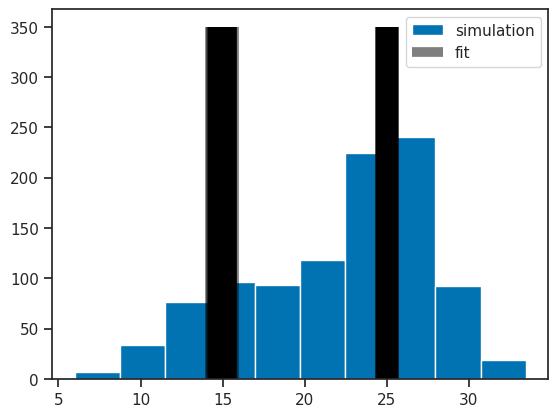

In [8]:
# plot the fit mu onto the simulated data
mu = fit.stan_variable("mu").T
plt.hist(y_simu, label = 'simulation');
plt.vlines([mu[0], mu[1]], 0, 350, 
           linewidth = 7, alpha = 0.5, label = 'fit', color='k')
plt.legend()

## Direct modelling of the association

In more physical applications, we want to know the rigorous probability for the association of an observation $y_i$ with a population component $k$. In order to do this, we basically want the marginal posterior for $\lambda$.

There are two things we can do in Stan to provide some useful information on this probability. 

* Save the values of the log probability `lp[i, k]` which correspsonds to $p(\lambda, y | \mu, \sigma)$. These can be marginalised to give $p(\lambda | \mu, \sigma, y)$
* Generate discrete samples based on `lp[i, k]` using a categorical RNG.

In [9]:
# compile a new model for the problem
direct_model_file = 'stan/simple_mixture_direct.stan'
direct_model = cmdstanpy.CmdStanModel(stan_file=direct_model_file)

In [10]:
# fit this model
direct_fit = direct_model.sample(data=data, iter_sampling=1000, 
                                    chains=4, seed=42, show_progress=False)

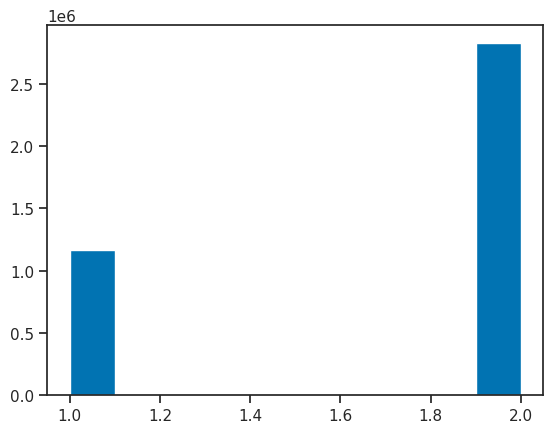

In [11]:
# plot the sampled labels (bit boring as we only have 2 components)
lam = direct_fit.stan_variable("lambda").flatten()
plt.hist(lam);

### Probability that observation $i$ comes from component $k$

For each observation $y_i$, the value of the log probability `lp[i, k]` is the log of $p(\lambda = k, y_i | \mu, \sigma)$. Averaging over the posterior draws gives $q(\lambda = k | y_i, \mu, \sigma)$, which can be normalised to give the final result:

$$
p(\lambda = k | y_i, \mu, \sigma) = \frac{q(\lambda = k | y_i, \mu, \sigma)}{\sum_l q(\lambda = l | y_i, \mu, \sigma)}
$$

In [12]:
logprob = direct_fit.stan_variable("lp").transpose(1, 2, 0)
np.shape(logprob)

(1000, 2, 4000)

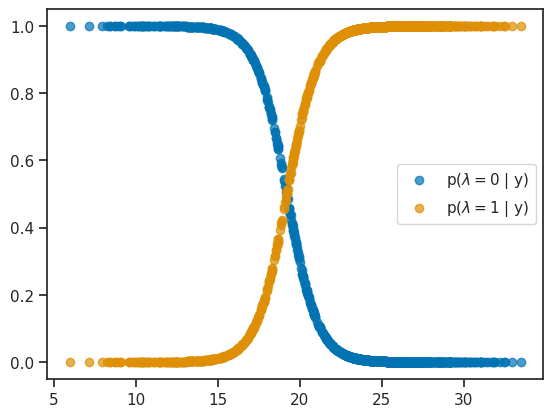

In [13]:
# answer: what is the probability that observation i comes from component k?

# find normalised marginal probability 
# associated with each observation
lp_l0 = []
lp_l1 = []
prob_l0 = []
prob_l1 = []
for i in range(len(y_simu)):
    # extract all iterations for all chains
    lp_i_l0 = logprob[i][0]
    lp_i_l1 = logprob[i][1]
    # exponentiate and average
    lp_l0.append(np.mean(np.exp(lp_i_l0)))
    lp_l1.append(np.mean(np.exp(lp_i_l1)))
    # normalise
    norm = (lp_l0[i] + lp_l1[i])
    prob_l0.append(lp_l0[i] / norm)
    prob_l1.append(lp_l1[i] / norm)

# plot the probabilities for different values of y_i
plt.scatter(y_simu, prob_l0, alpha = 0.7, label = 'p($\lambda = 0$ | y)')
plt.scatter(y_simu, prob_l1, alpha = 0.7, label = 'p($\lambda = 1$ | y)')
plt.legend()

## Parallelising the mixture likelihood

We can use Stan's `map_rect()` for within-chain parallelisation of the mixture likelihood, but then in order to preserve the component label information we need to also evaluate the likelihood in the generated quantities block, as shown in `stan/simple_mixture_parallel.stan`. This won't slow things down much, as no gradients are evaluated for code in the generated quantities block. So, we will have a net speed up.

An example that tries to pass the likelihood values directly out of the `lp_reduce` function is given in `stan/simple_mixture_parallel_fail.stan` - so named because doing this results in much longer runtimes.

In [20]:
# compile a new model for the problem
parallel_model_file = 'stan/simple_mixture_parallel.stan'
cpp_options = {"STAN_THREADS": True}
parallel_model = cmdstanpy.CmdStanModel(stan_file=parallel_model_file, cpp_options=cpp_options)

In [21]:
nshards = 4
data["N_shards"] = nshards
data["M"] = ceil(data["N_obs"]/data["N_shards"])
parallel_fit = parallel_model.sample(data=data, iter_sampling=1000, 
                                     chains=4, seed=42, threads_per_chain=nshards,
                                     show_progress=False, show_console=False)

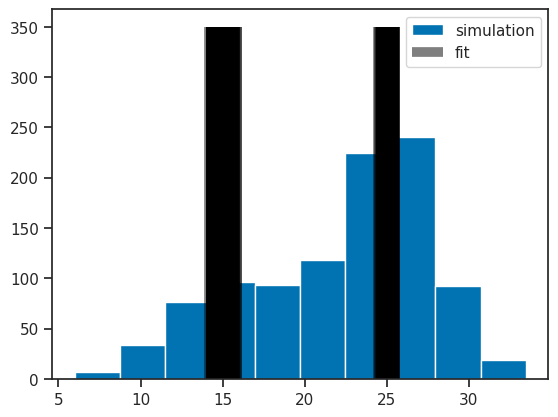

In [25]:
# plot the fit mu onto the simulated data
mu = parallel_fit.stan_variable("mu").T
plt.hist(y_simu, label = 'simulation');
plt.vlines([mu[0], mu[1]], 0, 350, 
           linewidth = 7, alpha = 0.5, label = 'fit', color='k')
plt.legend()

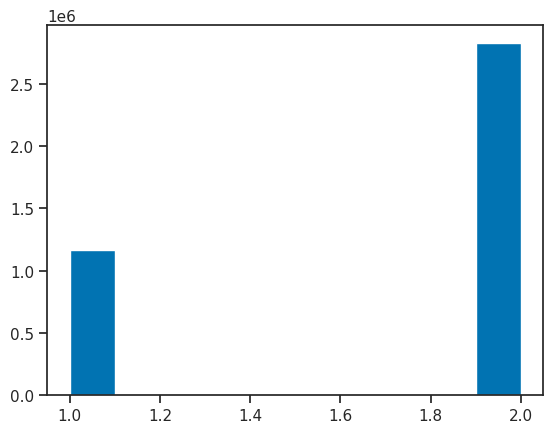

In [26]:
# plot the sampled labels (bit boring as we only have 2 components)
lam = parallel_fit.stan_variable("lambda").flatten()
plt.hist(lam);

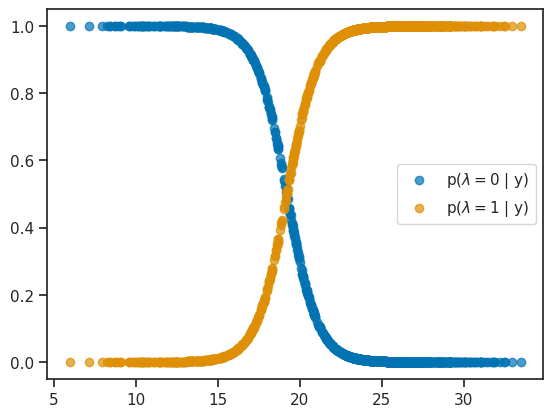

In [27]:
# Evaluate association probability, as above
logprob = direct_fit.stan_variable("lp").transpose(1, 2, 0)

lp_l0 = []
lp_l1 = []
prob_l0 = []
prob_l1 = []

for i in range(len(y_simu)):

    lp_i_l0 = logprob[i][0]
    lp_i_l1 = logprob[i][1]

    lp_l0.append(np.mean(np.exp(lp_i_l0)))
    lp_l1.append(np.mean(np.exp(lp_i_l1)))

    norm = (lp_l0[i] + lp_l1[i])
    prob_l0.append(lp_l0[i] / norm)
    prob_l1.append(lp_l1[i] / norm)

plt.scatter(y_simu, prob_l0, alpha = 0.7, label = 'p($\lambda = 0$ | y)')
plt.scatter(y_simu, prob_l1, alpha = 0.7, label = 'p($\lambda = 1$ | y)')
plt.legend()